In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
np.random.seed(1234)

In [3]:
N1 = 30
N2 = 20
Y1 = np.random.normal(size=N1, loc=0, scale=5)
Y2 = np.random.normal(size=N2, loc=1, scale=4)

## 分布の確認

C:\Users\eX\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


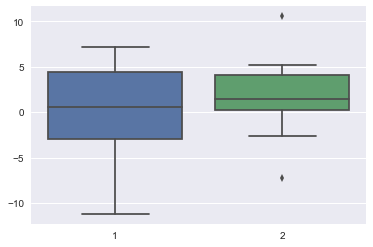

In [4]:
sns.boxplot(y=np.r_[Y1,Y2], x=np.r_[[1]*N1, [2]*N2])
plt.show()

## モデル式の記述

$Y1[n1]$ ~ $Normal(\mu1, \sigma)$

$Y2[n2]$ ~ $Normal(\mu2, \sigma)$


## Stanでの実装

In [5]:
model_code = '''data {
  int N1;
  int N2;
  real Y1[N1];
  real Y2[N2];  
}
parameters {
  real mu1;
  real mu2;
  real<lower=0> sigma;
}
model {
  for (n1 in 1:N1)
    Y1[n1] ~ normal(mu1, sigma);
  for (n2 in 1:N2)
    Y2[n2] ~ normal(mu2, sigma);
}
'''

In [6]:
from pystan import StanModel
sm = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8d3dc4acd4719a0443ff05a8699070dc NOW.


In [7]:
data = dict(N1=N1, N2=N2, Y1=Y1, Y2=Y2)
fit = sm.sampling(data=data, n_jobs=1)

## Prob [mu1 < mu2] の計算

In [8]:
ms = fit.extract()
d_mcmc = pd.DataFrame(data=dict(mu1=ms['mu1'], mu2=ms['mu2'], sigma=ms['sigma']))
d_mcmc.head()

,mu1,mu2,sigma
0,-1.322819,1.396826,4.097944
1,0.362634,1.710892,4.870167
2,-0.805141,2.807613,4.456291
3,1.333244,2.386141,4.927645
4,-0.091503,1.935662,5.062094


In [9]:
d_mcmc['mu1<mu2'] = d_mcmc.mu1 <  d_mcmc.mu2
p = d_mcmc['mu1<mu2'].sum() / len(d_mcmc['mu1<mu2']) 
print('Prob[mu1<mu2]: {}%'.format(p*100))

Prob[mu1<mu2]: 88.325%


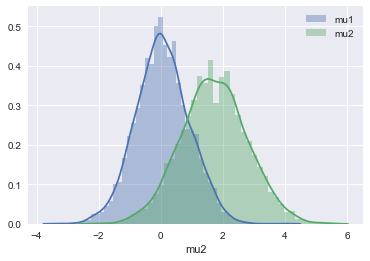

In [10]:
sns.distplot(d_mcmc.mu1, label='mu1')
sns.distplot(d_mcmc.mu2, label='mu2')
plt.legend()
plt.show()

## 標準偏差が異なるとした場合のProb [mu1 < mu2] の計算

$Y1[n1]$ ~ $Normal(\mu1, \sigma1)$

$Y2[n2]$ ~ $Normal(\mu2, \sigma2)$


In [11]:
model_code = '''data {
  int N1;
  int N2;
  real Y1[N1];
  real Y2[N2];  
}
parameters {
  real mu1;
  real mu2;
  real<lower=0> sigma1;
  real<lower=0> sigma2;
}
model {
  for (n1 in 1:N1)
    Y1[n1] ~ normal(mu1, sigma1);
  for (n2 in 1:N2)
    Y2[n2] ~ normal(mu2, sigma2);
}
'''

In [12]:
from pystan import StanModel
sm = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f6b5cbe1bf54fb1dcdaa1cf320c8978d NOW.


In [13]:
data = dict(N1=N1, N2=N2, Y1=Y1, Y2=Y2)
fit = sm.sampling(data=data, n_jobs=1)

In [14]:
ms = fit.extract()
d_mcmc = pd.DataFrame(data=dict(mu1=ms['mu1'], mu2=ms['mu2'], sigma1=ms['sigma1'],sigma2=ms['sigma2']))
d_mcmc.head()

,mu1,mu2,sigma1,sigma2
0,1.883796,-0.364804,5.220834,3.805379
1,-0.415478,2.335887,4.995408,3.515514
2,-0.184206,1.597100,4.411053,3.949864
3,-0.612471,2.494669,5.408088,4.181645
4,0.999642,1.403439,5.882469,3.242254


In [15]:
d_mcmc['mu1<mu2'] = d_mcmc.mu1 <  d_mcmc.mu2
p = d_mcmc['mu1<mu2'].sum() / len(d_mcmc['mu1<mu2']) 
print('Prob[mu1<mu2]: {}%'.format(p*100))

Prob[mu1<mu2]: 89.875%


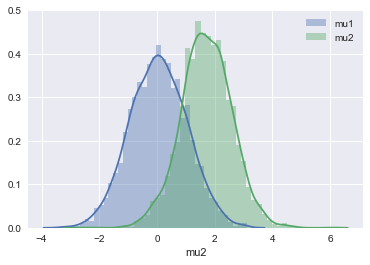

In [16]:
sns.distplot(d_mcmc.mu1, label='mu1')
sns.distplot(d_mcmc.mu2, label='mu2')
plt.legend()
plt.show()